# Anomaly Detection with GANs for Multivariate Time Series
https://arxiv.org/pdf/1809.04758.pdf

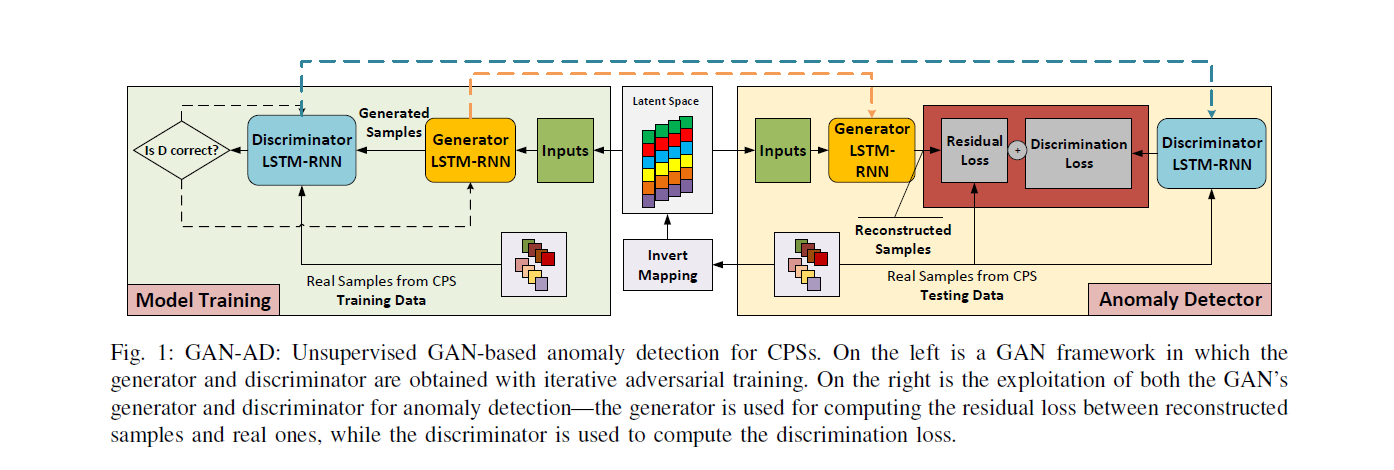

In [164]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import *

import pandas as pd
from typing import Optional, Iterable

## Data loading

In [130]:
data = []
for root, dirs, files in os.walk("../datasets/skab/valve1/"):
    for file in files:
        if file.endswith(".csv"):
             data.append(os.path.join(root, file))

In [131]:
df_data = pd.concat([pd.read_csv(time_series, index_col='datetime', sep=';',parse_dates=True) for time_series in data]).reset_index(drop=True) 
# TODO/NOTES using datetime as feature or drop the datetime?

In [132]:
df_data

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
0,0.026588,0.040111,1.330200,0.054711,79.3366,26.0199,233.062,32.0,0.0,0.0
1,0.026170,0.040453,1.353990,0.382638,79.5158,26.0258,236.040,32.0,0.0,0.0
2,0.026199,0.039419,1.540060,0.710565,79.3756,26.0265,251.380,32.0,0.0,0.0
3,0.026027,0.039641,1.334580,0.382638,79.6097,26.0393,234.392,32.0,0.0,0.0
4,0.026290,0.040273,1.078510,-0.273216,79.6109,26.0420,225.342,32.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
18157,0.028524,0.041076,0.622684,0.054711,67.6205,24.7763,233.878,32.0,0.0,0.0
18158,0.028092,0.041769,0.882653,0.054711,67.4618,24.7776,213.745,32.0,0.0,0.0
18159,0.027999,0.041164,0.569926,0.382638,67.6600,24.7834,224.067,32.0,0.0,0.0
18160,0.027862,0.041963,0.945311,-0.273216,67.6663,24.7752,235.491,32.0,0.0,0.0


## Data pre-processing

In [133]:
# removing the labels
df_data = df_data.drop(columns=['anomaly','changepoint'])

In [134]:
# spliting data to train and test, 75:25 ratio
ratio = 0.75
split = int(len(df_data)*ratio)

X_train_raw = df_data.iloc[:split,:].reset_index(drop=True) 
X_test_raw = df_data.iloc[split:,:].reset_index(drop=True) 

In [105]:
# TODO normalizing the data ?

In [106]:
# def divide_time_series(time_series, window_size, shift):
#     divided = [time_series[i:i+window_size] for i in range(0,len(time_series)-window_size,shift)]
#     return np.stack(divided)

# X_train = divide_time_series(X_train_raw, window_size, train_shift)
# X_test = divide_time_series(X_test_raw, window_size, test_shift)

# print(X_train.shape)
# print(X_test.shape)

In [ ]:
# TODO PCA ???

In [161]:
# values selected at random (for now)
window_size = 50
train_shift = 5
test_shift = 50
batch_size = 30

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array
X_train = tf.keras.preprocessing.timeseries_dataset_from_array(X_train_raw.astype(np.float),
                                targets=None, sequence_length=window_size, sequence_stride=train_shift, batch_size=batch_size)

X_test = tf.keras.preprocessing.timeseries_dataset_from_array(X_test_raw.astype(np.float),
                                targets=None, sequence_length=window_size, sequence_stride=test_shift, batch_size=batch_size)

# TODO how to drop_remainder?

## Model architecture and loss functions

In [167]:
def get_D_loss(real, generated):
    real_loss = BinaryCrossentropy(tf.ones_like(real), real)
    generated_loss = BinaryCrossentropy(tf.zeros_like(generated), generated)
    d_loss = (real_loss + generated_loss)/len(real)
    return d_loss

In [ ]:
# "...the LSTM network for the discriminator is relatively simpler with 100 hidden units and depth 1..."
def build_discriminator(input_shape):
    data = Input(shape=(input_shape))
    
    x = LSTM(100)(data)
    decision = Dense(1, activation = 'sigmoid')(x)
    
    model = keras.Model(inputs=[data], outputs=[decision], name='discriminator')
    return model

In [168]:
def get_G_loss(generated):
    return BinaryCrossentropy(tf.ones_like(generated), generated)

In [ ]:
latent_dim = 15 # based on the paper

In [ ]:
# "...we used an LSTM network with depth 3 and 100 hidden (internal) units for the generator..."
def build_generator(latent_dim, output_shape):
    z = Input(shape=(latent_dim,))
    
    x = LSTM(10)(data)
    x = LSTM(100)(x)
    x = LSTM(10)(x)
    
    data = Dense(output_shape, activation = 'linear')(x)
    
    model = keras.Model(inputs=[z], outputs=[data], name='generator')
    return model

In [ ]:
def training_iterations(dataset, epochs):
    for epoch in range(epochs):
        for batch in dataset:
            # TODO

In [ ]:
def test_iterations(dataset, epochs):
    for epoch in range(epochs):
        for batch in dataset:
            # TODO

In [ ]:
def fit():
    # TODO training_iterations(dataset, epochs)
    # TODO test_iterations(dataset, epochs)
    # TODO calculate the residuals
    # TODO calculate the discrimination results
    # TODO obtain anomaly score

Training iterations

Mini-batch stochastic optimization
based on Adam Optimizer and Gradient Descent Optimizer is
used for updating the model parameters.

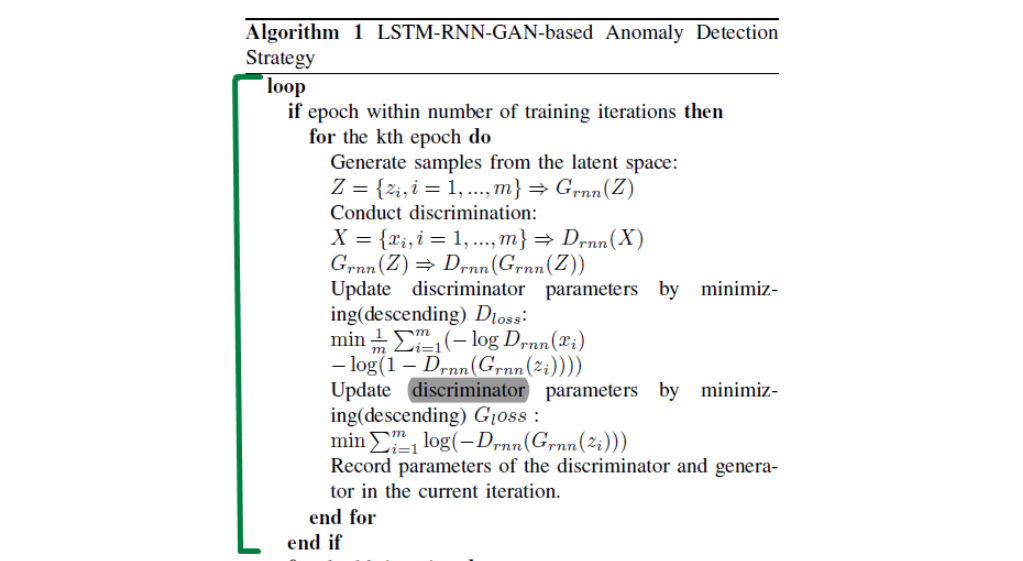

Test iterations

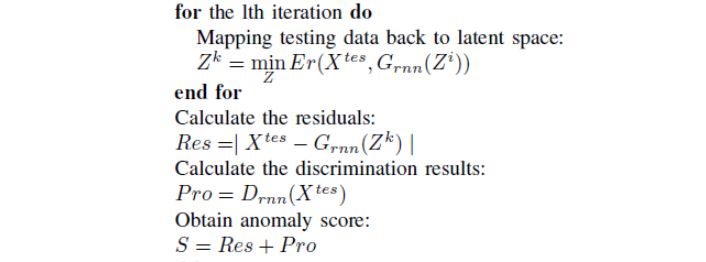

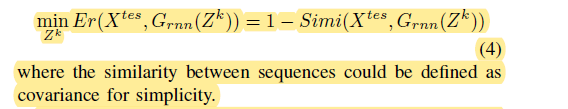

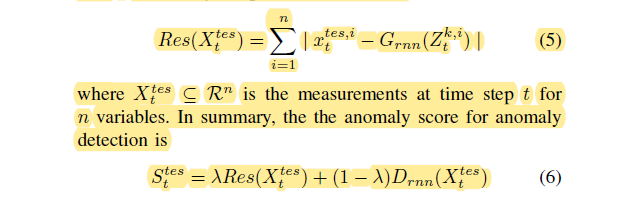

Anomaly detection - treshold

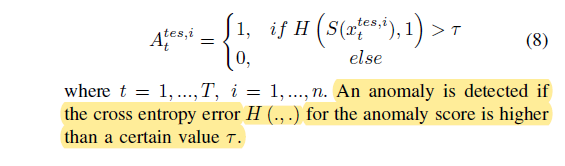

PCA

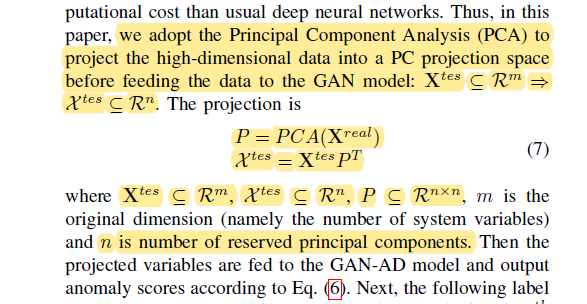

Architecture details

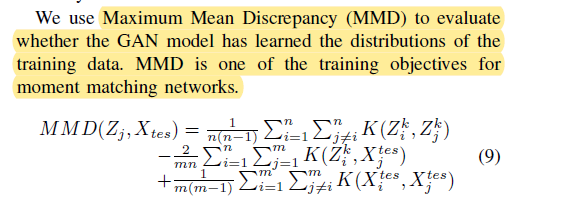

LSTMRNN cell
`class LSTMCell(RNNCell)` v `mod_core_rnn_cell_impl.py`

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTMCell

MMD `mmd.py`
Compare two models using relative MMD test ... `model_comparison` v `eval.py`

### Datamole's template, requirements :

The anomaly detector should be able to handle numerical data with missing values (nan values). In case the paper introducing the detector does not mention it and there is not a clear solution you can relax on it. For example in case the detector is working with certain window size, ignoring (window size - 1) samples after sample with a missing value is a possible solution (nan anomaly score should be returned for each ignored sample).

The anomaly detector must be able to handle multiple time series which are identified by the ID columns whose names are provided in the constructor argument `id_columns`. These columns should only be used to separate individual time series (not as feature columns). In case the paper introducing the detector does not mention training on multiple time series, try to come up with a reasonable solution. If there is not a clear reasonable solution you can relax on it.

In [ ]:
class GAN_AD(TimeSeriesAnomalyDetector):
    """
    Time series GAN anomaly detector.

    Parameters
    ----------
    id_columns: Iterable[str], optional
        ID columns used to identify individual time series.

        Should be specified in case the detector is provided with
        time series during training or inference with ID columns
        included. Using these columns the detector can separate individual
        time series and not use ID columns as feature columns.
        In case they are not specified, all columns are regarded as feature
        columns and the provided data is regarded as a single time series.
    """

    def __init__(
        self,
        id_columns: Optional[Iterable[str]] = None,
    ):
        super().__init__()
        self._id_columns = id_columns
        
    def predict_anomaly_scores(
            self, X: pd.DataFrame, *args, **kwargs
        ) -> pd.Series:
            """
            Predicts an anomaly score of the input samples. Samples should be
            ordered by their timestamps.

            An anomaly score is a measure of normality. The higher the score,
            the more abnormal the measured sample is.

            Parameters
            ----------
            X : pd.DataFrame, shape (n_samples, n_columns)
                The samples whose anomaly scores are to be predicted.
                The columns contain samples' features and possibly
                samples' identifiers.

            Returns
            -------
            scores : pd.Series, shape (n_samples,)
                The anomaly score of the input samples. The higher, the more
                abnormal.
            """
            # TODO: return predicted anomaly scores for the given samples

    def fit(self, X: pd.DataFrame, *args, **kwargs) -> None:
        """
        Fits the anomaly detector according to the given training data.

        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_columns)
            The training samples. The columns contain samples' features and
            possibly samples' identifiers.
        """
        # TODO: perform training